# Requirements


In [1]:
### PREREQUISTIES
### (many used only in one notebook...)

import os
import pandas as pd
import numpy as np
import pickle
import math
import random
import sys # to use your own functions
import io
import csv
from urllib.request import urlopen

import matplotlib.pyplot as plt

from scipy import stats

import gspread
from gspread_dataframe import get_as_dataframe, set_with_dataframe
from google.oauth2 import service_account # based on google-auth library

import sddk

In [2]:
conf = sddk.configure("SDAM_root", "648597@au.dk")

sciencedata.dk username (format '123456@au.dk'): 648597@au.dk
sciencedata.dk password: ········
connection with shared folder established with you as its owner
endpoint variable has been configured to: https://sciencedata.dk/files/SDAM_root/


In [3]:
### authorize google sheets
# to access our gsheet with data overview & metadata, you need a Google Service Account json file
# (see google-auth python package documentation to start with)
# I have mine located in my personal space on sciencedata.dk, so I read it from there:

# (1) read the file and parse its content
try:
    file_data = conf[0].get("https://sciencedata.dk/files/ServiceAccountsKey.json").json()
except:
    print("cannot find file ServiceAccountsKey.json")
# (2) transform the content into crendentials object
credentials = service_account.Credentials.from_service_account_info(file_data)
# (3) specify your usage of the credentials
scoped_credentials = credentials.with_scopes(['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive'])
# (4) use the constrained credentials for authentication of gspread package
gc = gspread.Client(auth=scoped_credentials)
# (5) establish connection with spreadsheets specified by their url
sh = gc.open_by_url("https://docs.google.com/spreadsheets/d/1boQal2mG8j_FK7XpxYM7iwIwK7Q_8ErTuor2_jC333o/edit?usp=sharing")

In [4]:
sh.worksheets()

[<Worksheet 'Sheet1' id:0>,
 <Worksheet 'seshat_axial_1000BC-1CE' id:1499875099>,
 <Worksheet 'latium_data' id:2003450966>]

# Variables

In [14]:
mg_vars = pd.read_csv("https://raw.githubusercontent.com/pesavage/moralizing-gods/master/variables.csv")
mg_vars.head(5)

,Variable,Subsection,ShortName,Category,VarNumber,Section
0,Polity Population,Social Scale,PolPop,scale,1,Social Complexity variables
1,Polity territory,Social Scale,PolTerr,scale,2,Social Complexity variables
2,Population of the largest settlement,Social Scale,CapPop,scale,3,Social Complexity variables
3,Administrative levels,Hierarchical Complexity,AdmLev,levels,4,Social Complexity variables
4,Military levels,Hierarchical Complexity,MilLev,levels,5,Social Complexity variables


In [15]:
mg_vars["Variable"].tolist()[:10]

['Polity Population',
 'Polity territory',
 'Population of the largest settlement',
 'Administrative levels',
 'Military levels',
 'Religious levels',
 'Settlement hierarchy',
 'Professional military officers',
 'Professional soldiers',
 'Professional priesthood']

In [16]:
mg_vars_dict = dict(zip(mg_vars["ShortName"], mg_vars["Variable"]))
mg_vars_dict

{'PolPop': 'Polity Population',
 'PolTerr': 'Polity territory',
 'CapPop': 'Population of the largest settlement',
 'AdmLev': 'Administrative levels',
 'MilLev': 'Military levels',
 'ReligLev': 'Religious levels',
 'SettlHier': 'Settlement hierarchy',
 'ProfOfficer': 'Professional military officers',
 'ProfSoldier': 'Professional soldiers',
 'ProfPriest': 'Professional priesthood',
 'FullTBur': 'Full-time bureaucrats',
 'ExamSyst': 'Examination system',
 'MeritProm': 'Merit promotion',
 'GovtBldg': 'Specialized government buildings',
 'Court': 'Courts',
 'LegCode': 'Formal legal code',
 'Judge': 'Judges',
 'Lawyer': 'Professional Lawyers',
 'Irrigation': 'irrigation systems',
 'WaterSuppl': 'drinking water supply systems',
 'Market': 'markets',
 'FoodStor': 'food storage sites',
 'Road': 'Roads',
 'Bridge': 'Bridges',
 'Canal': 'Canals',
 'Port': 'Ports',
 'Mine': 'Mines or quarries',
 'Courier': 'Couriers',
 'PostStation': 'Postal stations',
 'PostService': 'General postal service',
 

In [17]:
mg_vars_dict_inverse = dict(zip(mg_vars["Variable"], mg_vars["ShortName"]))
mg_vars_dict_inverse

{'Polity Population': 'PolPop',
 'Polity territory': 'PolTerr',
 'Population of the largest settlement': 'CapPop',
 'Administrative levels': 'AdmLev',
 'Military levels': 'MilLev',
 'Religious levels': 'ReligLev',
 'Settlement hierarchy': 'SettlHier',
 'Professional military officers': 'ProfOfficer',
 'Professional soldiers': 'ProfSoldier',
 'Professional priesthood': 'ProfPriest',
 'Full-time bureaucrats': 'FullTBur',
 'Examination system': 'ExamSyst',
 'Merit promotion': 'MeritProm',
 'Specialized government buildings': 'GovtBldg',
 'Courts': 'Court',
 'Formal legal code': 'LegCode',
 'Judges': 'Judge',
 'Professional Lawyers': 'Lawyer',
 'irrigation systems': 'Irrigation',
 'drinking water supply systems': 'WaterSuppl',
 'markets': 'Market',
 'food storage sites': 'FoodStor',
 'Roads': 'Road',
 'Bridges': 'Bridge',
 'Canals': 'Canal',
 'Ports': 'Port',
 'Mines or quarries': 'Mine',
 'Couriers': 'Courier',
 'Postal stations': 'PostStation',
 'General postal service': 'PostService',
 

In [18]:
rel_variables = ["SEFair", "SERecip",  "SEIngroup", "HighGods"]
for variable_short in rel_variables:
  print(mg_vars_dict[variable_short])


supernatural enforcement of fairness
supernatural enforcement of human reciprocity
supernatural enforcement of in-group loyalty
High Gods (creator gods)


# Aggregated data

In [3]:
MIoutput = sddk.read_file("SDAM_data/seshat/moralizing-gods_20190325/MIoutput.csv", "df", conf)
MIoutput.reset_index(inplace=True)
MIoutput.head()

,NGA,PolID,Date,PropCoded,PolPop,PolTerr,CapPop,AdmLev,MilLev,ReligLev,...,SEProperty,SEKinship,SEIngroup,SERespect,SEBravery,SEPurity,SEGeneral,SEAmoral,SEAmoral.1,HeredStatus
0,Big Island Hawaii,Hawaii1,1000,76.5,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Big Island Hawaii,Hawaii1,1100,76.5,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Big Island Hawaii,Hawaii2,1200,86.3,6226.481277,2691.464917,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Big Island Hawaii,Hawaii2,1300,86.3,7790.267324,2691.464917,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Big Island Hawaii,Hawaii2,1400,86.3,15481.783212,2691.464917,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
### regional constraints to AM
NGA_AM = ["Latium", "Paris Basin", "Upper Egypt", "Konya Plain"]
### temporal constraints to AM
dates_AM = [num*100 for num in range(-10, 11)]

In [4]:
MIoutput_latium = MIoutput[(MIoutput["NGA"]=="Latium") & (MIoutput["Date"] >= -1000) & (MIoutput["Date"] <= 1000)]
MIoutput_latium

,NGA,PolID,Date,PropCoded,PolPop,PolTerr,CapPop,AdmLev,MilLev,ReligLev,...,SEProperty,SEKinship,SEIngroup,SERespect,SEBravery,SEPurity,SEGeneral,SEAmoral,SEAmoral.1,HeredStatus
365,Latium,ItLatIA,-1000,84.3,NaN,NaN,2.266248e+02,1.402916,2.076203,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
366,Latium,ItLatIA,-900,84.3,NaN,NaN,2.266248e+02,1.402916,2.076203,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
367,Latium,ItLatIA,-800,84.3,NaN,NaN,1.641409e+02,1.402916,2.076203,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
368,Latium,ItRomRg,-700,84.3,5.028575e+04,1.000000e+03,1.391944e+04,3.000000,4.594214,1.885673,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
369,Latium,ItRomRg,-600,84.3,5.028575e+04,1.000000e+03,2.709729e+04,3.000000,4.594214,1.885673,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
370,Latium,ItRomER,-500,98.0,1.000000e+05,1.000000e+03,3.000000e+04,3.000000,6.000000,4.000000,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
371,Latium,ItRomER,-400,98.0,1.500000e+05,1.000000e+03,3.000000e+04,3.000000,6.000000,4.000000,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
372,Latium,ItRomER,-300,98.0,7.296585e+05,2.777762e+04,5.485737e+04,3.000000,6.000000,4.000000,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
373,Latium,ItRomMR,-200,98.0,3.943613e+06,7.300000e+05,2.100000e+05,3.199749,6.000000,4.000000,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
374,Latium,ItRomLR,-100,98.0,2.829306e+07,3.500000e+06,4.000000e+05,3.452204,7.000000,4.000000,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
MIoutput_latium = MIoutput[(MIoutput["NGA"]=="Latium") & (MIoutput["Date"] >= -1000) & (MIoutput["Date"] <= 1000)]
MIoutput_latium[["NGA", "PolID", "Date"] + rel_variables]

,NGA,PolID,Date,SEFair,SERecip,SEIngroup,HighGods
365,Latium,ItLatIA,-1000,NaN,NaN,NaN,0.0
366,Latium,ItLatIA,-900,NaN,NaN,NaN,0.0
367,Latium,ItLatIA,-800,NaN,NaN,NaN,0.0
368,Latium,ItRomRg,-700,NaN,NaN,NaN,0.0
369,Latium,ItRomRg,-600,NaN,NaN,NaN,0.0
370,Latium,ItRomER,-500,0.0,1.0,1.0,0.0
371,Latium,ItRomER,-400,0.0,1.0,1.0,0.0
372,Latium,ItRomER,-300,0.0,1.0,1.0,0.0
373,Latium,ItRomMR,-200,0.0,1.0,1.0,0.0
374,Latium,ItRomLR,-100,0.0,1.0,1.0,0.0


In [5]:
MIAggrDat = sddk.read_file("SDAM_data/seshat/moralizing-gods_20190325/MIAggrDat.csv", "df", conf).reset_index()

In [6]:
MIAggrDat.head()

,NGA,PolID,Time,PropCoded,PolPop,PolTerr,CapPop,levels,government,infrastr,...,ConformityDR,MHG,BSP,WrittenRecords,ReligiousHier,GeneralMoralisticPunishment,MoralisingHighGods,MoralisingGods,DoctrinalMode,Writing
0,Big Island Hawaii,Hawaii1,1000,76.5,NaN,NaN,NaN,NaN,0.090909,0.100000,...,NaN,NaN,NaN,0.1,NaN,NaN,NaN,NaN,NaN,0.0
1,Big Island Hawaii,Hawaii2,1200,86.3,6226.481277,2691.464917,NaN,NaN,0.090909,0.090909,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0
2,Big Island Hawaii,Hawaii2,1300,86.3,7790.267324,2691.464917,NaN,NaN,0.090909,0.090909,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0
3,Big Island Hawaii,Hawaii2,1400,86.3,15481.783212,2691.464917,NaN,NaN,0.090909,0.181818,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0
4,Big Island Hawaii,Hawaii2,1500,86.3,18957.125564,2691.464917,NaN,NaN,0.172727,0.181818,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0


In [7]:
MIAggrDat_latium = MIAggrDat[(MIAggrDat["NGA"]=="Latium") & (MIAggrDat["Time"] >= -1000) & (MIAggrDat["Time"] <= 1000)]

In [8]:
MIAggrDat_latium

,NGA,PolID,Time,PropCoded,PolPop,PolTerr,CapPop,levels,government,infrastr,...,ConformityDR,MHG,BSP,WrittenRecords,ReligiousHier,GeneralMoralisticPunishment,MoralisingHighGods,MoralisingGods,DoctrinalMode,Writing
155,Latium,ItLatIA,-1000,84.3,NaN,NaN,2.266248e+02,1.495824,0.090909,0.150000,...,NaN,0.0,NaN,0.1,1.000000,NaN,0.0,NaN,NaN,0.0
156,Latium,ItLatIA,-800,84.3,NaN,NaN,1.641409e+02,1.495824,0.090909,0.150000,...,NaN,0.0,NaN,0.1,1.000000,NaN,0.0,NaN,NaN,0.0
157,Latium,ItRomRg,-700,84.3,5.028575e+04,1.000000e+03,1.391944e+04,2.781649,0.263636,0.483333,...,NaN,0.0,NaN,1.0,1.885673,NaN,0.0,NaN,1.0,1.0
158,Latium,ItRomRg,-600,84.3,5.028575e+04,1.000000e+03,2.709729e+04,2.781649,0.254545,0.483333,...,NaN,0.0,NaN,1.0,1.885673,NaN,0.0,NaN,1.0,1.0
159,Latium,ItRomER,-500,98.0,1.000000e+05,1.000000e+03,3.000000e+04,3.400000,0.272727,0.658333,...,NaN,0.0,0.666667,1.0,4.000000,1.0,0.0,1.0,1.0,1.0
160,Latium,ItRomER,-400,98.0,1.500000e+05,1.000000e+03,3.000000e+04,3.400000,0.272727,0.658333,...,NaN,0.0,0.666667,1.0,4.000000,1.0,0.0,1.0,1.0,1.0
161,Latium,ItRomER,-300,98.0,7.296585e+05,2.777762e+04,5.485737e+04,4.000000,0.363636,0.658333,...,NaN,0.0,0.666667,1.0,4.000000,1.0,0.0,1.0,1.0,1.0
162,Latium,ItRomMR,-200,98.0,3.943613e+06,7.300000e+05,2.100000e+05,4.039950,0.363636,0.833333,...,NaN,0.0,0.666667,1.0,4.000000,1.0,0.0,1.0,1.0,1.0
163,Latium,ItRomLR,-100,98.0,2.829306e+07,3.500000e+06,4.000000e+05,4.690441,0.281818,0.833333,...,NaN,0.0,0.666667,1.0,4.000000,1.0,0.0,1.0,1.0,1.0
164,Latium,ItRomPr,0,98.0,5.000000e+07,4.500000e+06,1.047796e+06,7.091997,0.645455,0.991667,...,NaN,0.0,0.666667,1.0,4.000000,1.0,0.0,1.0,1.0,1.0


In [25]:
rel_variables_aggr = ["MHG", "BSP", "GeneralMoralisticPunishment", "MoralisingHighGods", "MoralisingGods"]
MIAggrDat_latium[["NGA", "PolID", "Time"] + rel_variables_aggr]

,NGA,PolID,Time,MHG,BSP,GeneralMoralisticPunishment,MoralisingHighGods,MoralisingGods
155,Latium,ItLatIA,-1000,0.0,NaN,NaN,0.0,NaN
156,Latium,ItLatIA,-800,0.0,NaN,NaN,0.0,NaN
157,Latium,ItRomRg,-700,0.0,NaN,NaN,0.0,NaN
158,Latium,ItRomRg,-600,0.0,NaN,NaN,0.0,NaN
159,Latium,ItRomER,-500,0.0,0.666667,1.0,0.0,1.0
160,Latium,ItRomER,-400,0.0,0.666667,1.0,0.0,1.0
161,Latium,ItRomER,-300,0.0,0.666667,1.0,0.0,1.0
162,Latium,ItRomMR,-200,0.0,0.666667,1.0,0.0,1.0
163,Latium,ItRomLR,-100,0.0,0.666667,1.0,0.0,1.0
164,Latium,ItRomPr,0,0.0,0.666667,1.0,0.0,1.0


In [26]:
### it seems that "GeneralMoralisticPunishment" and "MoralisingGods" are identical variables

MIAggrDat[["GeneralMoralisticPunishment", "MoralisingGods"]].corr()

,GeneralMoralisticPunishment,MoralisingGods
GeneralMoralisticPunishment,1.0,1.0
MoralisingGods,1.0,1.0


In [27]:
mg_vars["Variable"].unique().tolist()

['Polity Population',
 'Polity territory',
 'Population of the largest settlement',
 'Administrative levels',
 'Military levels',
 'Religious levels',
 'Settlement hierarchy',
 'Professional military officers',
 'Professional soldiers',
 'Professional priesthood',
 'Full-time bureaucrats',
 'Examination system',
 'Merit promotion',
 'Specialized government buildings',
 'Courts',
 'Formal legal code',
 'Judges',
 'Professional Lawyers',
 'irrigation systems',
 'drinking water supply systems',
 'markets',
 'food storage sites',
 'Roads',
 'Bridges',
 'Canals',
 'Ports',
 'Mines or quarries',
 'Couriers',
 'Postal stations',
 'General postal service',
 'Mnemonic devices',
 'Nonwritten records',
 'Written records',
 'Script',
 'Non-phonetic writing',
 'Phonetic alphabetic writing',
 'Lists tables and classifications',
 'Calendar',
 'Sacred Texts',
 'Religious literature',
 'Practical literature',
 'History',
 'Philosophy',
 'Scientific literature',
 'Fiction',
 'Articles',
 'Tokens',
 'Pre

In [28]:
mg_vars.head(5)

,Variable,Subsection,ShortName,Category,VarNumber,Section
0,Polity Population,Social Scale,PolPop,scale,1,Social Complexity variables
1,Polity territory,Social Scale,PolTerr,scale,2,Social Complexity variables
2,Population of the largest settlement,Social Scale,CapPop,scale,3,Social Complexity variables
3,Administrative levels,Hierarchical Complexity,AdmLev,levels,4,Social Complexity variables
4,Military levels,Hierarchical Complexity,MilLev,levels,5,Social Complexity variables


In [31]:
Vars = sddk.read_file("SDAM_data/seshat/moralizing-gods_20190325/Vars.csv", "df", conf)
Vars.head()

,Variable,Subsection,ShortName,Category,VarNumber,Section
1,Social Scale Polity Population,Social Scale,PolPop,scale,1,Social Complexity variables
2,Social Scale Polity territory,Social Scale,PolTerr,scale,2,Social Complexity variables
3,Social Scale Population of the largest settlement,Social Scale,CapPop,scale,3,Social Complexity variables
4,Hierarchical Complexity Administrative levels,Hierarchical Complexity,AdmLev,levels,4,Social Complexity variables
5,Hierarchical Complexity Military levels,Hierarchical Complexity,MilLev,levels,5,Social Complexity variables


In [32]:
for var_short in Vars["ShortName"].unique().tolist():
  if not var_short in mg_vars["ShortName"].unique().tolist():
    print(var_short)

In [33]:
Vars["Variable"].unique().tolist()

['Social Scale Polity Population',
 'Social Scale Polity territory',
 'Social Scale Population of the largest settlement',
 'Hierarchical Complexity Administrative levels',
 'Hierarchical Complexity Military levels',
 'Hierarchical Complexity Religious levels',
 'Hierarchical Complexity Settlement hierarchy',
 'Professions Professional military officers',
 'Professions Professional soldiers',
 'Professions Professional priesthood',
 'Bureaucracy characteristics Full-time bureaucrats',
 'Bureaucracy characteristics Examination system',
 'Bureaucracy characteristics Merit promotion',
 'Bureaucracy characteristics Specialized government buildings',
 'Law Courts',
 'Law Formal legal code',
 'Law Judges',
 'Law Professional Lawyers',
 'Specialized Buildings: polity owned irrigation systems',
 'Specialized Buildings: polity owned drinking water supply systems',
 'Specialized Buildings: polity owned markets',
 'Specialized Buildings: polity owned food storage sites',
 'Specialized Buildings: 

# SCdat.csv

`SCdat.csv` is output of `precheck.R`.

It is basically a cleaned version of the raw data.

In [35]:
SCdat = sddk.read_file("SDAM_data/seshat/moralizing-gods_20190325/SCdat.csv", "df", conf).reset_index()
SCdat.head()

,NGA,Polity,Variable,Value.From,Value.To,Date.From,Date.To,Fact.Type,Value.Note,Date.Note
0,Latium,ItLatCA,Hierarchical Complexity Administrative levels,1.0,NaN,NaN,NaN,simple,simple,NaN
1,Latium,ItLatCA,Hierarchical Complexity Military levels,1.0,NaN,NaN,NaN,simple,simple,NaN
2,Latium,ItLatCA,Hierarchical Complexity Religious levels,1.0,NaN,NaN,NaN,simple,simple,NaN
3,Latium,ItLatCA,Hierarchical Complexity Settlement hierarchy,1.0,NaN,NaN,NaN,simple,simple,NaN
4,Latium,ItLatCA,Professions Professional military officers,0.0,NaN,NaN,NaN,simple,simple,NaN


In [36]:
len(SCdat)

19427

In [0]:
### how many of them are individually dated?
len(SCdat[SCdat["Date.From"].isnull()])

18109

In [37]:
SCdat["Variable"].unique().tolist()

['Hierarchical Complexity Administrative levels',
 'Hierarchical Complexity Military levels',
 'Hierarchical Complexity Religious levels',
 'Hierarchical Complexity Settlement hierarchy',
 'Professions Professional military officers',
 'Professions Professional soldiers',
 'Professions Professional priesthood',
 'Bureaucracy characteristics Full-time bureaucrats',
 'Bureaucracy characteristics Examination system',
 'Bureaucracy characteristics Merit promotion',
 'Bureaucracy characteristics Specialized government buildings',
 'Law Courts',
 'Law Formal legal code',
 'Law Judges',
 'Law Professional Lawyers',
 'Specialized Buildings: polity owned irrigation systems',
 'Specialized Buildings: polity owned drinking water supply systems',
 'Specialized Buildings: polity owned markets',
 'Specialized Buildings: polity owned food storage sites',
 'Specialized Buildings: polity owned Roads',
 'Specialized Buildings: polity owned Bridges',
 'Specialized Buildings: polity owned Canals',
 'Speci

In [38]:
len(SCdat)

19427

In [39]:
len(SCdat[(SCdat["Value.Note"].isin(["disputed", "uncertain"]))])

349

In [40]:
len(SCdat[(SCdat["NGA"]=="Latium")])

1201

In [41]:
len(SCdat[(SCdat["NGA"]=="Latium") & (SCdat["Value.Note"].isin(["disputed", "uncertain"]))])

32

In [42]:
table_df = SCdat[(SCdat["NGA"]=="Latium") & (SCdat["Polity"]=="ItRomPr") & (SCdat["Variable"]=="Social Scale Population of the largest settlement")]
table_df

,NGA,Polity,Variable,Value.From,Value.To,Date.From,Date.To,Fact.Type,Value.Note,Date.Note
573,Latium,ItRomPr,Social Scale Population of the largest settlement,900000.0,1100000.0,1.0,NaN,complex,range,simple
574,Latium,ItRomPr,Social Scale Population of the largest settlement,1000000.0,1200000.0,100.0,NaN,complex,range,simple
575,Latium,ItRomPr,Social Scale Population of the largest settlement,1000000.0,NaN,200.0,NaN,complex,simple,simple


In [52]:
seshat_mg = pd.read_csv("https://raw.githubusercontent.com/pesavage/moralizing-gods/28794692f2615bfdedcf037b186bd8d5e54c10b4/exportdat.csv")
seshat_mg.shape

(47613, 13)

In [53]:
### the variables are divided into several sections
seshat_mg["Section"].unique()

array(['General variables', 'Religion and Normative Ideology',
       'Ritual variables', 'Social Complexity variables', 'General'],
      dtype=object)

In [54]:
### and we are especially interested in the sections associated with religion
seshat_mg[seshat_mg["Section"]=="Religion and Normative Ideology"]["Variable"].unique().tolist()

['High Gods (creator gods)',
 'supernatural enforcement of fairness',
 'supernatural enforcement of human reciprocity',
 'supernatural enforcement of in-group loyalty',
 'alternate Names of Official Cult',
 'Name of Official Cult',
 'Name of other significant religious or ideological systems',
 'RA',
 'Description of the Normative Ideology',
 'Expert',
 'Creator Gods',
 'Editor']

In [55]:
seshat_mg[seshat_mg["Section"]=="Ritual variables"]["Variable"].unique().tolist()

['RA',
 'Frequency for the audience',
 'Frequency for the ritual specialist',
 'Frequency per participant',
 'Name',
 'Name_1',
 'Frequency for the participants']

In [56]:
### some variable values have specified dates
### however, most of them are defined on a polity basis 
print(seshat_mg["Date From"].unique().tolist())

[nan, '1200CE', '1500CE', '1300CE', '1400CE', '1550CE', '1390CE', '1580CE', '1631CE', '1691', '1711', '1755BCE', '1756CE', '1818', '1840', '1827', '1835', '1823CE', '1853CE', '1800CE', '1660CE', '1682CE', '1700CE', '1685CE', '1715CE', '1745CE', '1789CE', '1650CE', '1750CE', '1673CE', '1600CE', '1718CE', '900CE', '1000CE', '1050CE', '1080CE', '1113CE', '800CE', '1596CE', '1633CE', '1782CE', '1862CE', '1850CE', '1857CE', '500CE', '700CE', '1100CE', '732CE', '899CE', '1222CE', '1255CE', '1886CE', '1915CE', '1947CE', '1561CE', '1601CE', '1606CE', '1640CE', '200CE', '300CE', '400CE', '1250CE', '1350CE', '1375CE', '1438CE', '1430CE', '1480CE', '1532CE', '600CE', '1150CE', '1200BCE', '999BCE', '599BCE', '1206CE', '1296CE', '400BCE', '500BCE', '1526CE', '100BCE', '1CE', '100CE', '101CE', '1714CE', '1790CE', '1713CE', '1566CE', '1702CE', '1703CE', '1832CE', '1791CE', '1829CE', '1821CE', '1900CE', '1956CE', '1863CE', '1873CE', '1874CE', '1056CE', '930CE', '1262CE', '1030CE', '1051CE', '1201CE', 

In [57]:
### we can look in more detail on Latium
NGA_df = seshat_mg[seshat_mg["NGA"]=="Latium"]
NGA_df.head(5)

,NGA,Polity,Section,Subsection,Variable,Value From,Value To,Date From,Date To,Fact Type,Value Note,Date Note,Comment
17598,Latium,FrAvign,General variables,NaN,Alternative names,Avignon Period,NaN,NaN,NaN,complex,list,NaN,NaN
17599,Latium,FrAvign,General variables,NaN,Alternative names,Avignon Papacy,NaN,NaN,NaN,complex,list,NaN,NaN
17600,Latium,FrAvign,General variables,NaN,Duration,1309-1378 CE,NaN,NaN,NaN,simple,simple,NaN,NaN
17601,Latium,FrAvign,General variables,NaN,Original name,Papal State,NaN,NaN,NaN,simple,simple,NaN,NaN
17602,Latium,ItBenLP,General variables,NaN,Alternative names,Benevento,NaN,NaN,NaN,complex,list,NaN,NaN


In [58]:
polity = "ItBenLP"
NGA_df[(NGA_df["Polity"]==polity)& (NGA_df["Variable"]=="Duration")]["Value From"]

17607    570-774 CE
Name: Value From, dtype: object

In [59]:
### to export it out into an independent dataset
# set_with_dataframe(sh.add_worksheet("latium_data", rows=1, cols=1), NGA_df)

In [60]:
import ast
import re

In [61]:
def get_bce_or_ce(raw_date):
  try: 
    if "BCE" in raw_date:
      return int(raw_date.replace("BCE", "")) * -1
    else:
      return int(raw_date.replace("CE", ""))
  except:
      return None 
seshat_mg["date_from"] = seshat_mg.apply(lambda row: get_bce_or_ce(row["Date From"]) , axis=1)
seshat_mg["date_to"] = seshat_mg.apply(lambda row: get_bce_or_ce(row["Date To"]) , axis=1)

In [62]:
polities_duration = {}
for polity in seshat_mg["Polity"].unique():
  try:
    duration_raw = seshat_mg[(seshat_mg["Polity"]==polity)& (seshat_mg["Variable"]=="Duration")]["Value From"].values[0]
  except:
    duration_list = [None, None]
  if ("BCE" in duration_raw) and (" CE" in duration_raw):
    duration_list = ast.literal_eval("[" + input("list values for range " + duration_raw + ": ") + "]")
  else:
    if "BCE" in duration_raw:
      duration_list = ["-" + tup.replace(" ", "") for tup in re.split(r"-|–", duration_raw.replace("BCE", ""))]
    else: 
      duration_list = [tup.replace(" ", "") for tup in  re.split(r"-|–", duration_raw.replace("CE", ""))]
  try:
    duration_list = [int(el) for el in duration_list]
  except:
    duration_list = ast.literal_eval("[" + input("list values for range " + duration_raw + ": ") + "]")
    duration_list = [int(l0), int(l1)]
  polities_duration[polity] = duration_list

list values for range 150 BCE - 300 CE: 
list values for range 400 BCE - 500 CE: 
list values for range 500BCE-200 CE: 
list values for range 100 BCE - 200 CE: 
list values for range 247 BCE - 40 CE: 
list values for range 12 BCE - 100 CE: 
list values for range 300 BCE - 250 CE: 
list values for range 31 BCE - 284 CE: 
list values for range 780-404 bce: 


NameError: name 'l0' is not defined

In [0]:
write_file("SDAM_data/seshat/polities_duration.json", polities_duration, conf)

Your <class 'dict'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/seshat/polities_duration.json"


In [0]:
polities_duration = read_file("SDAM_data/seshat/polities_duration.json", "dict", conf)
polities_duration["ItLatBA"] = [-1800, -900]
polities_duration

{'AfAfshr': [1736, 1858],
 'AfDurrn': [1747, 1826],
 'AfGhazn': [1450, 1589],
 'AfGhurd': [1025, 1215],
 'AfGrBct': [-256, -125],
 'AfHepht': [408, 561],
 'AfHerat': [1336, 1383],
 'AfKidar': [388, 477],
 'AfKushn': [35, 319],
 'AfTochr': [-129, 29],
 'Ashanti': [1701, 1895],
 'British colonial period and early independent India': [1867, 1956],
 'Brooke Raj and Colonial Period': [1841, 1987],
 'Cahokia extra: 1000-2000 CE': [1718, 1763],
 'Cn5Dyna': [907, 960],
 'CnChuSA': [-740, -489],
 'CnChuWS': [-488, -223],
 'CnEHan*': [25, 220],
 'CnErJin': [265, 317],
 'CnErlig': [-1650, -1250],
 'CnErlit': [-1850, -1600],
 'CnHChin': [1895, 1941],
 'CnHQngL': [1701, 1895],
 'CnHanWS': [-403, -231],
 'CnImQin': [-338, -207],
 'CnJinSA': [-12, 100],
 'CnLngsh': [-3000, -1900],
 'CnLrJin': [1115, 1243],
 'CnMing*': [1359, 1513],
 'CnNQi**': [550, 577],
 'CnNSong': [960, 1127],
 'CnNWei*': [386, 534],
 'CnNZhou': [557, 581],
 'CnQiSA*': [-12, 100],
 'CnQiWS': [480, 221],
 'CnQingE': [1644, 1796],
 

In [0]:
seshat_mg["polity_duration"] = seshat_mg.apply(lambda row: polities_duration[row["Polity"]], axis=1)

In [0]:
seshat_mg

,NGA,Polity,Section,Subsection,Variable,Value From,Value To,Date From,Date To,Fact Type,Value Note,Date Note,Comment,date_from,date_to,polity_duration
0,Big Island Hawaii,Hawaii1,General variables,NaN,Alternative names,Big Island of Hawaii,NaN,NaN,NaN,complex,list,NaN,NaN,NaN,NaN,"[1000, 1200]"
1,Big Island Hawaii,Hawaii1,General variables,NaN,Alternative names,Hawaii Island,NaN,NaN,NaN,complex,list,NaN,NaN,NaN,NaN,"[1000, 1200]"
2,Big Island Hawaii,Hawaii1,General variables,NaN,Alternative names,Island of Hawaii,NaN,NaN,NaN,complex,list,NaN,NaN,NaN,NaN,"[1000, 1200]"
3,Big Island Hawaii,Hawaii1,General variables,NaN,Alternative names,Big Island,NaN,NaN,NaN,complex,list,NaN,NaN,NaN,NaN,"[1000, 1200]"
4,Big Island Hawaii,Hawaii1,General variables,NaN,Alternative names,Owyhee,NaN,NaN,NaN,complex,list,NaN,NaN,NaN,NaN,"[1000, 1200]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47608,Yemeni Coastal Plain,YeZiyad,Social Complexity variables,Specialized Buildings: polity owned,Communal buildings,present,NaN,NaN,NaN,simple,simple,NaN,NaN,NaN,NaN,"[822, 1037]"
47609,Yemeni Coastal Plain,YeZiyad,Social Complexity variables,Specialized Buildings: polity owned,Knowledge/information buildings,inferred absent,NaN,NaN,NaN,simple,simple,NaN,NaN,NaN,NaN,"[822, 1037]"
47610,Yemeni Coastal Plain,YeZiyad,Social Complexity variables,Specialized Buildings: polity owned,Special purpose house,present,NaN,NaN,NaN,simple,simple,NaN,NaN,NaN,NaN,"[822, 1037]"
47611,Yemeni Coastal Plain,YeZiyad,Social Complexity variables,Specialized Buildings: polity owned,Symbolic buildings,inferred present,NaN,NaN,NaN,simple,simple,NaN,NaN,NaN,NaN,"[822, 1037]"


In [0]:
### for some variables, there is more than one value:
variable_df = seshat_mg[(seshat_mg["Polity"]=="Hawaii3") & (seshat_mg["Variable"]=="Degree of centralization")]
variable_df

,NGA,Polity,Section,Subsection,Variable,Value From,Value To,Date From,Date To,Fact Type,Value Note,Date Note,Comment,date_from,date_to,polity_duration
187,Big Island Hawaii,Hawaii3,General variables,NaN,Degree of centralization,unitary state,NaN,1580CE,1630CE,complex,simple,range,NaN,1580.0,1630.0,"[1580, 1778]"
188,Big Island Hawaii,Hawaii3,General variables,NaN,Degree of centralization,quasipolity,NaN,1631CE,1690CE,complex,simple,range,NaN,1631.0,1690.0,"[1580, 1778]"
189,Big Island Hawaii,Hawaii3,General variables,NaN,Degree of centralization,loose,NaN,1691,1710,complex,simple,range,NaN,1691.0,1710.0,"[1580, 1778]"
190,Big Island Hawaii,Hawaii3,General variables,NaN,Degree of centralization,unitary state,NaN,1711,1752,complex,simple,range,NaN,1711.0,1752.0,"[1580, 1778]"
191,Big Island Hawaii,Hawaii3,General variables,NaN,Degree of centralization,quasipolity,NaN,1755BCE,1753BCE,complex,simple,range,NaN,-1755.0,-1753.0,"[1580, 1778]"
192,Big Island Hawaii,Hawaii3,General variables,NaN,Degree of centralization,unitary state,NaN,1756CE,1778CE,complex,simple,range,NaN,1756.0,1778.0,"[1580, 1778]"


In [0]:
import collections

In [0]:
%%time

def get_row_values(row):
  values = [row["Value From"]]
  try: values[0] = float(values[0])
  except: pass
  value_to = row["Value To"]
  if ~np.isnan(value_to):
    values = [(values[0], value_to)]
  dates = (row["date_from"], row["date_to"])
  if ~np.isnan(dates[0]):
    values = values + [dates]
  try: 
    values = sorted(set(values))
  except:
    pass
  if len(values) == 1:
    values = values[0]
  return values

def get_single_value(values_data): ### if there is only one element use it!
  if isinstance(values_data, collections.MutableSequence):
    b = 1
    try:
      values_data = sorted(set(values_data))
      if len(values_data) == 1:
        values_data = values_data[0]
    except: pass
  return values_data

polities = {}
for NGA in seshat_mg["NGA"].unique().tolist():
  for polity in seshat_mg[seshat_mg["NGA"]==NGA]["Polity"].unique():
    polity_row = {}
    polity_row["NGA"] = NGA
    polity_row["duration"] = polities_duration[polity]
    polity_df = seshat_mg[seshat_mg["Polity"]==polity]
    for variable in polity_df["Variable"].unique().tolist():
      variable_df = polity_df[polity_df["Variable"]==variable]
      variable_values = [] 
      for ind in variable_df.index:
        variable_values.append(get_row_values(variable_df.loc[ind]))
      variable_values = get_single_value(variable_values)
      try: variable_short_name = mg_vars_dict[variable]
      except: variable_short_name = variable
      polity_row[variable_short_name] = variable_values
    polities[polity] = polity_row

CPU times: user 1min 6s, sys: 206 ms, total: 1min 6s
Wall time: 1min 6s


In [0]:
len(polities)

448

In [0]:
seshat_df = pd.DataFrame(polities).T
seshat_df

,NGA,duration,General variables/Alternative names,General variables/Capital,General variables/Degree of centralization,General variables/Duration,General variables/Expert,General variables/Language,General variables/Linguistic family,General variables/Original name,General variables/Peak Date,General variables/RA,General variables/succeeding (quasi)polity,General variables/Supra-polity relations,General variables/UTM zone,Religion and Normative Ideology/High Gods (creator gods),Religion and Normative Ideology/supernatural enforcement of fairness,Religion and Normative Ideology/supernatural enforcement of human reciprocity,Religion and Normative Ideology/supernatural enforcement of in-group loyalty,Religion and Normative Ideology/alternate Names of Official Cult,Religion and Normative Ideology/Name of Official Cult,Religion and Normative Ideology/Name of other significant religious or ideological systems,Social Complexity variables/Examination system,Social Complexity variables/Full-time bureaucrats,Social Complexity variables/Merit promotion,Social Complexity variables/Source of support,Social Complexity variables/Specialized government buildings,Social Complexity variables/Calendar,Social Complexity variables/Fiction,Social Complexity variables/History,Social Complexity variables/Lists tables and classifications,Social Complexity variables/Non-phonetic alphabetic writing,Social Complexity variables/Philosophy,Social Complexity variables/Phonetic alphabetic writing,Social Complexity variables/Practical literature,Social Complexity variables/Religious literature,Social Complexity variables/Sacred Texts,Social Complexity variables/Scientific literature,Social Complexity variables/Script,Social Complexity variables/Time,...,Ritual variables/RA,Religion and Normative Ideology/RA,Religion and Normative Ideology/Expert,General/Alternative names,General/Capital,General/Degree of centralization,General/Duration,General/Language,General/Linguistic family,General/Original name,General/Peak Date,General/preceding (quasi)polity,General/RA,General/relationship to preceding (quasi)polity,General/scale of supra-cultural interaction,General/succeeding (quasi)polity,General/Supra-polity relations,General/Supracultural entity,General/UTM zone,Religion and Normative Ideology/Creator Gods,Social Complexity variables/Non written records,Social Complexity variables/Drinking water supply systems,Social Complexity variables/Food storage sites,Social Complexity variables/Markets,Social Complexity variables/Non-phonetic writing,Social Complexity variables/Irrigation systems,Ritual variables/Name_1,General variables/Editer,General variables/succeeding (quasi) polity,Social Complexity variables/Editor,Social Complexity variables/Professional lawyers,Social Complexity variables/Philosophy_1,Ritual variables/Frequency for the participants,Social Complexity variables/Population of the largest settlement_1,General variables/Original name_1,Social Complexity variables/Time_1,General variables/Linguistic Family,General variables/Religious Tradition,General variables/Religion-Family,General variables/Religion-Sect
Hawaii1,Big Island Hawaii,"[1000, 1200]","[ Big Island, Hawaii, Hawaii Island, Island...",none,nominal,1000-1200 CE,PRG,Old Hawaiian,Austronesian,Hawaii,1200 CE,"[ Enrico Cioni, Enrico Cioni, PRG]",Hawaii2,unknown,5Q,suspected unknown,suspected unknown,suspected unknown,suspected unknown,suspected unknown,suspected unknown,suspected unknown,inferred absent,inferred absent,inferred absent,inferred absent,inferred absent,inferred absent,inferred absent,inferred absent,inferred absent,inferred absent,inferred absent,inferred absent,inferred absent,inferred absent,inferred absent,inferred absent,inferred absent,inferred present,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Hawaii2,Big Island Hawaii,"[1200, 1580]",Big Island of Hawai’i Hawa

In [0]:
seshat_df.to_csv("seshat_df.csv")
files.download("seshat_df.csv")

In [0]:
seshat_df.loc["Hawaii1"]["RA"]

[' Enrico Cioni', 'Enrico Cioni', 'PRG']

In [0]:
### manual correction
seshat_df.loc["ItLatBA", "duration"] = [-1800, -900]

In [0]:
write_file("SDAM_data/seshat/seshat_df.json", seshat_df, conf)

A file with the same name ("seshat_df.json") already exists in this location.
Press Enter to overwrite it or choose different path and filename: 
Your <class 'pandas.core.frame.DataFrame'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/seshat/seshat_df.json"


# Start with restructurized data

In [0]:
seshat_df = read_file("SDAM_data/seshat/seshat_df.json", "df", conf)
seshat_df

,NGA,duration,Alternative names,Capital,Degree of centralization,Duration,Expert,Language,Linguistic family,Original name,Peak Date,RA,succeeding (quasi)polity,Supra-polity relations,UTM zone,High Gods (creator gods),supernatural enforcement of fairness,supernatural enforcement of human reciprocity,supernatural enforcement of in-group loyalty,alternate Names of Official Cult,Name of Official Cult,Name of other significant religious or ideological systems,Examination system,Full-time bureaucrats,Merit promotion,Source of support,Specialized government buildings,Calendar,Fiction,History,Lists tables and classifications,Non-phonetic alphabetic writing,Philosophy,Phonetic alphabetic writing,Practical literature,Religious literature,Sacred Texts,Scientific literature,Script,Time,...,Military levels,Religious levels,Settlement hierarchy,Area,Geometrical,Length,Volume,Weight,Largest communication distance,Population of the largest settlement,Symbolic buildings,scale of supra-cultural interaction,Supracultural entity,Mnemonic devices,Other site,Other,Occupational complexity,cost,Editor,Written records_1,Creator Gods,Non written records,Drinking water supply systems,Food storage sites,Markets,Non-phonetic writing,Irrigation systems,Name_1,Editer,succeeding (quasi) polity,Professional lawyers,Philosophy_1,Frequency for the participants,Population of the largest settlement_1,Original name_1,Time_1,Linguistic Family,Religious Tradition,Religion-Family,Religion-Sect
Hawaii1,Big Island Hawaii,"[1000, 1200]",Big Island of Hawaii,none,nominal,1000-1200 CE,PRG,Old Hawaiian,Austronesian,Hawaii,1200 CE,Enrico Cioni,Hawaii2,unknown,5Q,suspected unknown,suspected unknown,suspected unknown,suspected unknown,suspected unknown,suspected unknown,suspected unknown,inferred absent,inferred absent,inferred absent,inferred absent,inferred absent,inferred absent,inferred absent,inferred absent,inferred absent,inferred absent,inferred absent,inferred absent,inferred absent,inferred absent,inferred absent,inferred absent,inferred absent,inferred present,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
Hawaii2,Big Island Hawaii,"[1200, 1580]",Big Island of Hawai’i Hawai’i Island Island of...,None,quasipolity,1200-1580 CE,PRG,Hawaiian,Austronesian,Hawai’i,1580 CE,Enrico Cioni,Hawaii 3,unknown,5Q,suspected unknown,suspected unknown,suspected unknown,suspected unknown,suspected unknown,suspected unknown,suspected unknown,inferred absent,inferred absent,inferred absent,None,inferred absent,absent,absent,absent,absent,None,absent,absent,absent,absent,absent,absent,absent,None,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
Hawaii3,Big Island Hawaii,"[1580, 1778]",Big Island of Hawai’i Hawai’i Island Island of...,Kona District,unitary state,1580-1778 CE,PRG,Hawaiian,Austronesian,Hawai’i,None,Enrico Cioni,None,None,4Q,suspected unknown,suspected unknown,suspected unknown,suspected unknown,None,Hawaiian Religion,None,inferred absent,absent,inferred absent,None,inferred absent,absent,absent,absent,absent,None,absent,absent,absent,absent,absent,absent,absent,inferred present,...,"[3, 4.0]",2,2,inferred present,inferred present,inferred present,inferred present,inferred present,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
USHawai,Big Island Hawaii,"[1820, 1854]",Sandwich Islands Kingdom Kingdom of Hawai’i,Honolulu,unitary state,1820-1854 CE,PRG,Hawaiian,Austronesian,Kingdom of Hawaii,unknown,Enrico Cioni,None,nominal allegiance,4Q,moralizing,present,present,absent,None,Christianity,None,absent,absent,None,None,None,None,inferred absent,inferred absent,

In [0]:
print(seshat_df.columns.tolist())

['NGA', 'duration', 'Alternative names', 'Capital', 'Degree of centralization', 'Duration', 'Expert', 'Language', 'Linguistic family', 'Original name', 'Peak Date', 'RA', 'succeeding (quasi)polity', 'Supra-polity relations', 'UTM zone', 'High Gods (creator gods)', 'supernatural enforcement of fairness', 'supernatural enforcement of human reciprocity', 'supernatural enforcement of in-group loyalty', 'alternate Names of Official Cult', 'Name of Official Cult', 'Name of other significant religious or ideological systems', 'Examination system', 'Full-time bureaucrats', 'Merit promotion', 'Source of support', 'Specialized government buildings', 'Calendar', 'Fiction', 'History', 'Lists tables and classifications', 'Non-phonetic alphabetic writing', 'Philosophy', 'Phonetic alphabetic writing', 'Practical literature', 'Religious literature', 'Sacred Texts', 'Scientific literature', 'Script', 'Time', 'Written records', 'Courts', 'Formal legal code', 'Judges', 'Professional Lawyers', 'Couriers',

In [0]:
seshat_df[seshat_df["NGA"]=="Latium"]

,NGA,duration,Alternative names,Capital,Degree of centralization,Duration,Expert,Language,Linguistic family,Original name,Peak Date,RA,succeeding (quasi)polity,Supra-polity relations,UTM zone,High Gods (creator gods),supernatural enforcement of fairness,supernatural enforcement of human reciprocity,supernatural enforcement of in-group loyalty,alternate Names of Official Cult,Name of Official Cult,Name of other significant religious or ideological systems,Examination system,Full-time bureaucrats,Merit promotion,Source of support,Specialized government buildings,Calendar,Fiction,History,Lists tables and classifications,Non-phonetic alphabetic writing,Philosophy,Phonetic alphabetic writing,Practical literature,Religious literature,Sacred Texts,Scientific literature,Script,Time,...,Military levels,Religious levels,Settlement hierarchy,Area,Geometrical,Length,Volume,Weight,Largest communication distance,Population of the largest settlement,Symbolic buildings,scale of supra-cultural interaction,Supracultural entity,Mnemonic devices,Other site,Other,Occupational complexity,cost,Editor,Written records_1,Creator Gods,Non written records,Drinking water supply systems,Food storage sites,Markets,Non-phonetic writing,Irrigation systems,Name_1,Editer,succeeding (quasi) polity,Professional lawyers,Philosophy_1,Frequency for the participants,Population of the largest settlement_1,Original name_1,Time_1,Linguistic Family,Religious Tradition,Religion-Family,Religion-Sect
FrAvign,Latium,"[1309, 1378]",Avignon Period,None,None,1309-1378 CE,None,None,None,Papal State,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
ItBenLP,Latium,"[570, 774]",Benevento,Benevento,None,570-774 CE,None,Latin,Indo-European,Beneventum,None,Joe Figliulo-Rosswurm,None,nominal allegiance,33 T,None,None,None,None,None,None,None,inferred absent,present,inferred absent,state salary,present,present,inferred present,present,inferred present,None,None,present,present,present,present,None,present,present,...,None,None,None,present,inferred present,present,present,present,None,None,present,17000000,Latin Christendom,present,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
ItLatBA,Latium,"[-1800, -900]",Apennine culture,None,quasipolity,1800-900,None,Latin,Indo-European,Latium Bronze Age,None,Enrico Cioni,Iron Age Latium,None,35 T,absent,suspected unknown,suspected unknown,suspected unknown,None,None,None,absent,absent,absent,none,absent,absent,inferred absent,inferred absent,absent,None,inferred absent,inferred absent,inferred absent,inferred absent,inferred absent,inferred absent,inferred absent,absent,...,1,1,1,inferred absent,absent,inferred absent,inferred absent,inferred absent,None,"[20, 50.0]",None,None,Appenine culture,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
ItLatCA,Latium,"[-3600, -1800]",Eneolithic,none,quasipolity,3600-1800 BCE,suspected unknown,None,None,Latium Copper Age,None,Enrico Cioni,Bronze Age Latium,None,35 T,absent,suspected unknown,suspected unknown,suspected unknown,None,None,None,absent,absent,absent,none,absent,absent,inferred absent,inferred absent,absent,None,inferred absent,inferred absent,inferred absent,inferred absent,inferred absent,inferred absent,inferred absent,absent,...,1,1,1,inferred absent,absent,inferred absent,inferred absent,inferred absent,None,None,None,None,None,None,Shelters,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
ItLatIA,Latium,"[-1000, -580]",Latial Culture,None,None,1000-580 B

In [0]:
polities

{'FmTrukE': {'Administrative levels': (3664    2
   Name: Value From, dtype: object, 3664   NaN
   Name: Value To, dtype: float64), 'Alternative names': (3623        Truk
   3624     Trukese
   Name: Value From, dtype: object, 3623   NaN
   3624   NaN
   Name: Value To, dtype: float64), 'Area': (3668    absent
   Name: Value From, dtype: object, 3668   NaN
   Name: Value To, dtype: float64), 'Articles': (3694    present
   Name: Value From, dtype: object, 3694   NaN
   Name: Value To, dtype: float64), 'Bridges': (3709    present
   Name: Value From, dtype: object, 3709   NaN
   Name: Value To, dtype: float64), 'Burial site': (3710    inferred present
   Name: Value From, dtype: object, 3710   NaN
   Name: Value To, dtype: float64), 'Calendar': (3669    absent
   Name: Value From, dtype: object, 3669   NaN
   Name: Value To, dtype: float64), 'Canals': (3711    absent
   Name: Value From, dtype: object, 3711   NaN
   Name: Value To, dtype: float64), 'Capital': (3625    none
   Name: Valu

In [0]:
#### seshat_mg = seshat_mg[(seshat_mg["date_from"]>= -800) & (seshat_mg["date_from"] <= 400) & (seshat_mg["NGA"].isin(NGA_AM))]

In [0]:
seshat_social_comp_AM.set_index("date_from", inplace=True)

In [0]:
AM_biggest_settl = seshat_social_comp_AM[(seshat_social_comp_AM["Variable"]=="Population of the largest settlement") & (seshat_social_comp_AM["NGA"]=="Latium")].sort_values("date_from")


In [0]:
AM_biggest_settl["Value From"] = AM_biggest_settl["Value From"].astype(float)

In [0]:
x = AM_biggest_settl.index.tolist()
y = AM_biggest_settl["Value From"].tolist()

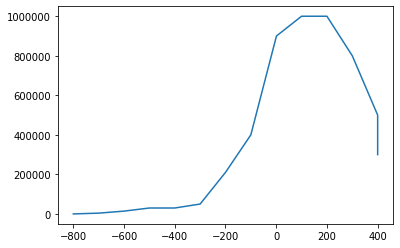

In [0]:
plt.plot(x, y)

# Latest version of the complete dataset

In [0]:
url = "http://seshatdatabank.info/2018csv/data/download.csv"
response = requests.get(url).text
file_object = io.StringIO(response)
seshat_complete = pd.read_csv(file_object)

In [0]:
seshat_complete.head()

,NGA,Polity,Section,Subsection,Variable,Value From,Value To,Date From,Date To,Fact Type,Value Note,Date Note,Comment
0,Ghanaian Coast,GhAshnE,Social Complexity variables,NaN,RA,Eva Brandl,NaN,NaN,NaN,simple,simple,NaN,NaN
1,Ghanaian Coast,GhAshnE,Social Complexity variables,NaN,Editor,Daniel Mullins,NaN,NaN,NaN,simple,simple,NaN,NaN
2,Ghanaian Coast,GhAshnE,Social Complexity variables,Hierarchical Complexity,Settlement hierarchy,3,NaN,NaN,NaN,simple,simple,NaN,NaN
3,Ghanaian Coast,GhAshnE,Social Complexity variables,Hierarchical Complexity,Administrative levels,4,NaN,NaN,NaN,simple,simple,NaN,NaN
4,Ghanaian Coast,GhAshnE,Social Complexity variables,Hierarchical Complexity,Religious levels,3,NaN,NaN,NaN,simple,simple,NaN,NaN


In [0]:
seshat_complete[seshat_complete["NGA"]=="Latium"]

,NGA,Polity,Section,Subsection,Variable,Value From,Value To,Date From,Date To,Fact Type,Value Note,Date Note,Comment
15030,Latium,ItLatCA,Social Complexity variables,NaN,RA,Enrico Cioni,NaN,NaN,NaN,complex,list,NaN,NaN
15031,Latium,ItLatCA,Social Complexity variables,NaN,RA,Edward A L Turner,NaN,NaN,NaN,complex,list,NaN,NaN
15032,Latium,ItLatCA,Social Complexity variables,Hierarchical Complexity,Settlement hierarchy,1,NaN,NaN,NaN,simple,simple,NaN,NaN
15033,Latium,ItLatCA,Social Complexity variables,Hierarchical Complexity,Administrative levels,1,NaN,NaN,NaN,simple,simple,NaN,NaN
15034,Latium,ItLatCA,Social Complexity variables,Hierarchical Complexity,Religious levels,1,NaN,NaN,NaN,simple,simple,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16590,Latium,ItPapM2,Social Complexity variables,Other,Store of wealth,present,NaN,NaN,NaN,simple,simple,NaN,NaN
16591,Latium,ItPapM2,Social Complexity variables,Other,Couriers,present,NaN,NaN,NaN,simple,simple,NaN,NaN
16592,Latium,ItPapM2,Social Complexity variables,Other,Postal stations,absent,NaN,NaN,NaN,simple,simple,NaN,NaN
16593,Latium,ItPapM2,Social Complexity variables,Other,General postal service,absent,NaN,NaN,NaN,simple,simple,NaN,NaN


In [0]:
variables = seshat_complete["Variable"].unique()
variables

array(['RA', 'Editor', 'Settlement hierarchy', 'Administrative levels',
       'Religious levels', 'Military levels', 'Occupational complexity',
       'Professional military officers', 'Professional soldiers',
       'Professional priesthood', 'Full-time bureaucrats',
       'Source of support', 'Examination system', 'Merit promotion',
       'Specialized government buildings', 'Formal legal code', 'Judges',
       'Courts', 'Professional Lawyers', 'Communal buildings',
       'Special purpose house', 'Utilitarian public buildings',
       'irrigation systems', 'drinking water supply systems', 'markets',
       'food storage sites', 'Symbolic buildings',
       'Entertainment buildings', 'Knowledge/information buildings',
       'Roads', 'Bridges', 'Canals', 'Ports', 'Special purpose sites',
       'Ceremonial site', 'Burial site', 'Trading emporia', 'Enclosures',
       'Mines or quarries', 'Other site', 'Length', 'Area', 'Volume',
       'Weight', 'Time', 'Geometrical', 'Other', 'Mn

In [0]:
NGAs = seshat_complete["NGA"].unique()
NGAs

array(['Ghanaian Coast', 'Niger Inland Delta', 'Upper Egypt', 'Iceland',
       'Paris Basin', 'Yemeni Coastal Plain', 'Konya Plain', 'Susiana',
       'Garo Hills', 'Orkhon Valley', 'Sogdiana', 'Kapuasi Basin',
       'Latium', 'Cambodian Basin', 'Kachi Plain', 'Southern China Hills',
       'Middle Yellow River Valley', 'Finger Lakes', 'Central Java',
       'Kansai', 'Lena River Valley', 'Deccan', 'Lowland Andes', 'Cuzco',
       'North Colombia', 'Oro PNG', 'Cahokia', 'Big Island Hawaii',
       'Valley of Oaxaca', 'Chuuk Islands'], dtype=object)

In [0]:
len(NGAs)

30

In [0]:
for region in NGAs:
  for date in seshat_complete[seshat_complete["NGA"]==region]["Date From"].tolist():
    print(region, date) ###seshat_complete[seshat_complete["Variable"]==variable][["NGA", "Date From", "Variable", "Value From"]].values)

Streaming output truncated to the last 5000 lines.
Kansai nan
Kansai nan
Kansai nan
Kansai nan
Kansai nan
Kansai nan
Kansai nan
Kansai nan
Kansai nan
Kansai nan
Kansai nan
Kansai 1185CE
Kansai 1226CE
Kansai nan
Kansai nan
Kansai nan
Kansai nan
Kansai nan
Kansai nan
Kansai nan
Kansai nan
Kansai nan
Kansai nan
Kansai nan
Kansai 1300CE
Kansai 1300CE
Kansai nan
Kansai nan
Kansai nan
Kansai nan
Kansai nan
Kansai nan
Kansai nan
Kansai nan
Kansai nan
Kansai nan
Kansai nan
Kansai nan
Kansai nan
Kansai nan
Kansai nan
Kansai nan
Kansai nan
Kansai nan
Kansai nan
Kansai nan
Kansai nan
Kansai nan
Kansai nan
Kansai nan
Kansai nan
Kansai nan
Kansai nan
Kansai nan
Kansai nan
Kansai nan
Kansai nan
Kansai nan
Kansai nan
Kansai nan
Kansai nan
Kansai nan
Kansai nan
Kansai nan
Kansai nan
Kansai nan
Kansai nan
Kansai nan
Kansai nan
Kansai nan
Kansai nan
Kansai nan
Kansai nan
Kansai nan
Kansai nan
Kansai nan
Kansai nan
Kansai nan
Kansai nan
Kansai nan
Kansai nan
Kansai nan
Kansai nan
Kansai nan
Kansai nan
Ka